In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pywt
import pandas as pd
import cmocean as cm
from scipy import signal

In [2]:
import matplotlib.dates as mdates

In [3]:
def create_white_noise(n: int,
                       period:float,
                       amp: float,
                       phase=None
                      ):
    from numpy import cos, pi
    """
    n: vecor length
    period: time
    amp: signal amplitude
    phase(optional): displacement of the wave with respect to the origin 
    """
    if phase:
        wave =[amp * cos((i*pi)/period + phase) for i in range(n)]
        wave = np.array(wave)
        return wave
    else:
        wave =[amp * cos((i*pi)/period) for i in range(n)]
        wave = np.array(wave)
        return wave

In [4]:
def add_noise(x:pd.Series, noise:np.asarray)->np.asarray:
    
    x_no_nan = x.copy()
    nan_idx = x_no_nan.isna()
    x_no_nan.loc[nan_idx] = 0
    
    r = x_no_nan + noise
    r = np.array(x_no_nan)
    return r

In [14]:
dfu = pd.read_csv('../data/boia/ul-boia-completo.csv', delimiter=';')
dfv = pd.read_csv('../data/boia/vl-boia-completo.csv', delimiter=';')

df_wind = pd.read_csv('../data/boia/vento/vento-boia-tratado.csv',delimiter=';')

In [15]:
len(dfu), len(dfv), len(df_wind)

(7016, 7016, 9126)

In [16]:
dfu.columns, print('\t'), df_wind.columns

(Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
        '13', '14', '15', '16', '17', '18', '19', 'time'],
       dtype='object'),
 None,
 Index(['wu', 'wv', 'datetime', 'year', 'month', 'day', 'time_num', 'wul',
        'wvl', 'wuh', 'wvh'],
       dtype='object'))

In [17]:
df_wind.datetime[7015], dfu.time[7015]

('2017-09-07 03:00:00+00:00', '2017-09-07 03:00:00')

In [18]:
df_wind.datetime[0], dfu.time[0]

('2016-11-18 20:00:00+00:00', '2016-11-18 20:00:00')

In [19]:
time = mdates.datestr2num(dfu.time[0:3000])

In [11]:
#wu = df_wind.iloc[0:3000, 0].copy()
#wv = df_wind.iloc[0:3000, 0].copy()

#cpar = dfv.iloc[0:3000, 8].copy()
#cper = dfv.iloc[0:3000, 8].copy()

In [22]:
#wu.isna().sum(), wv.isna().sum()

In [21]:
#cpar.isna().sum(), cper.isna().sum()

In [24]:
r1 = create_white_noise(n=3000,
                        period=1000,
                        amp=0.001,
                        phase=0.25*np.pi)

r2 = create_white_noise(n=3000,
                        period=1000,
                        amp=0.001,
                        phase=0)

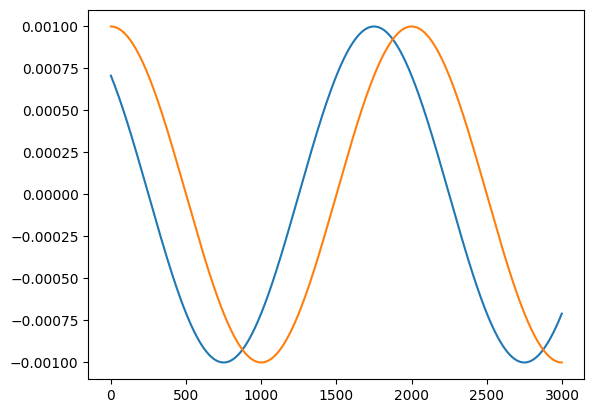

In [25]:
plt.plot(r1)
plt.plot(r2)

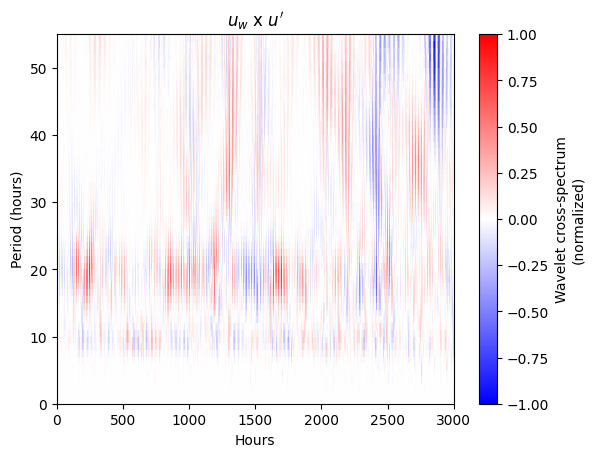

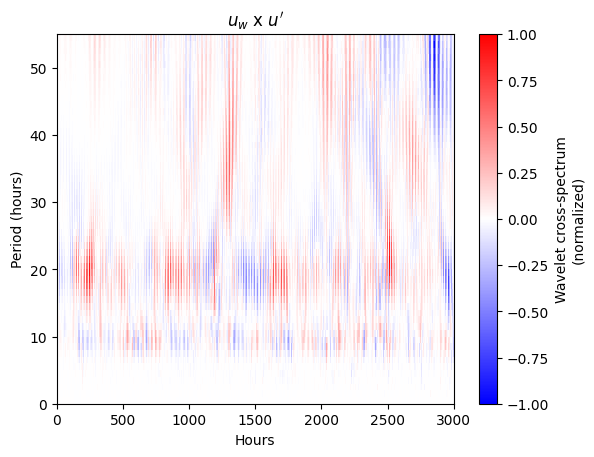

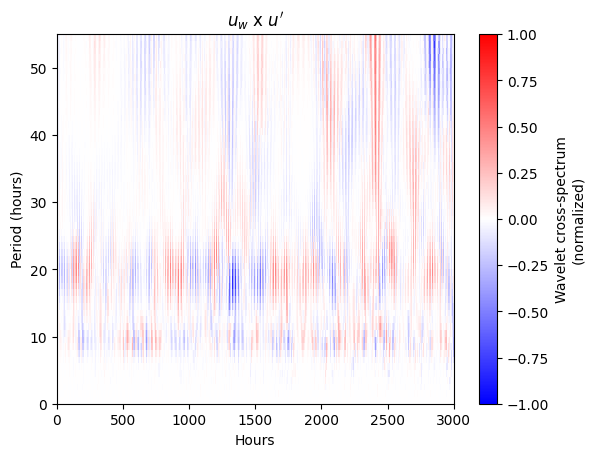

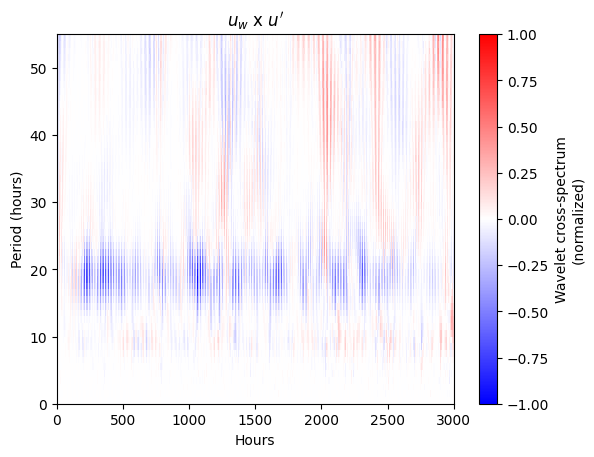

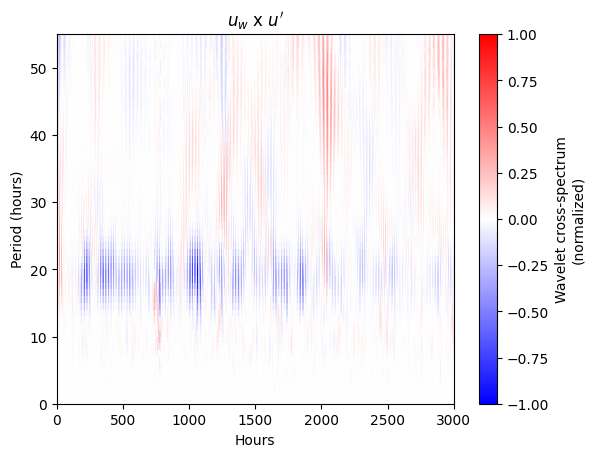

In [38]:
def cross_spectrum_cross_shore():

    for i in [1, 4, 10, 16, 19]:
        # Load data
        ocean_data = dfu.iloc[0:3000,i]
        ocean_data = add_noise(ocean_data, noise=r1)
        wind_data = add_noise(df_wind.wu.iloc[0:3000], noise=r1)

        # Define wavelet parameters
        dt = 1 # Time step of 1 hour
        scales = range(1, 56, 1) # Wavelet scales
        wavelet = 'morl' # Mother wavelet function

        # Perform wavelet analysis
        coefs_ocean, frequencies_ocean = pywt.cwt(ocean_data, scales, wavelet, dt)
        coefs_wind, frequencies_wind = pywt.cwt(wind_data, scales, wavelet, dt)

        # Calculate wavelet cross spectrum
        cross_spectrum = coefs_ocean * np.conj(coefs_wind)
        cross_spectrum = cross_spectrum/np.nanmax(abs(cross_spectrum))

        # Plot wavelet cross spectrum
        fig, ax = plt.subplots()
        cmap = plt.pcolormesh(np.real(cross_spectrum), vmin=-1, vmax=1, cmap=plt.cm.bwr)
        cbar = plt.colorbar(cmap)
        plt.title('$u_{w}$ x $u\'$')
        plt.xlabel('Hours')
        plt.ylabel('Period (hours)')
        cbar.set_label('Wavelet cross-spectrum\n(normalized)')
        plt.show()
        
cross_spectrum_cross_shore()

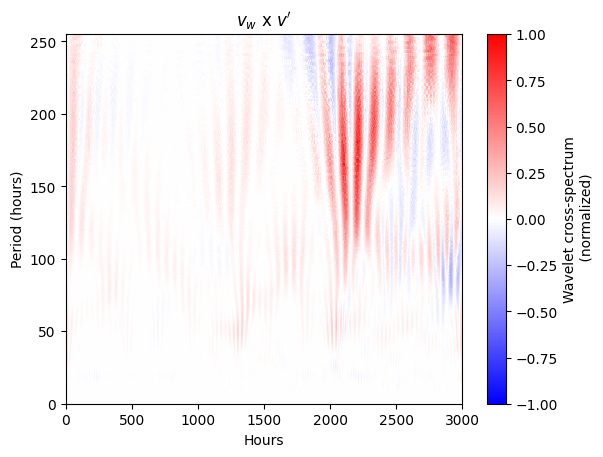

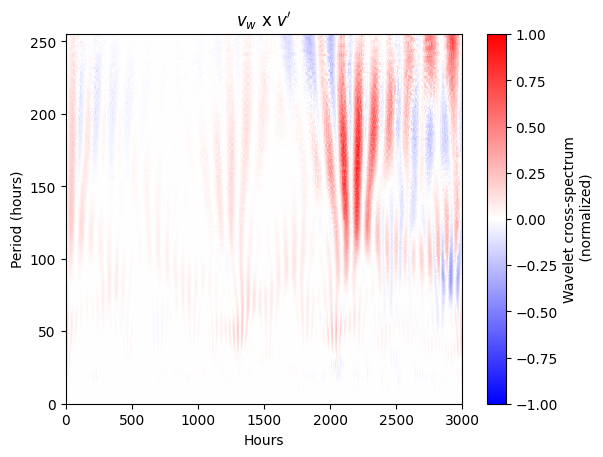

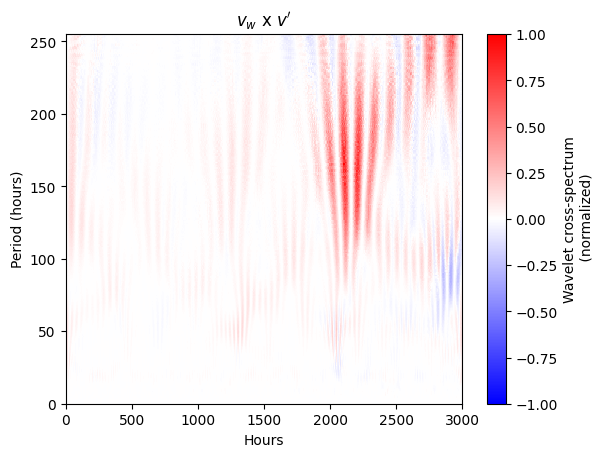

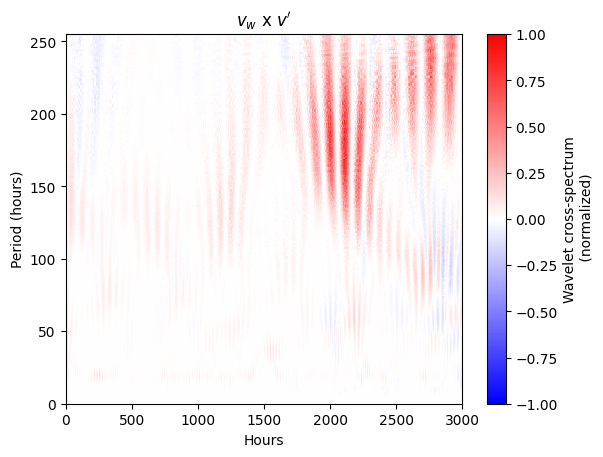

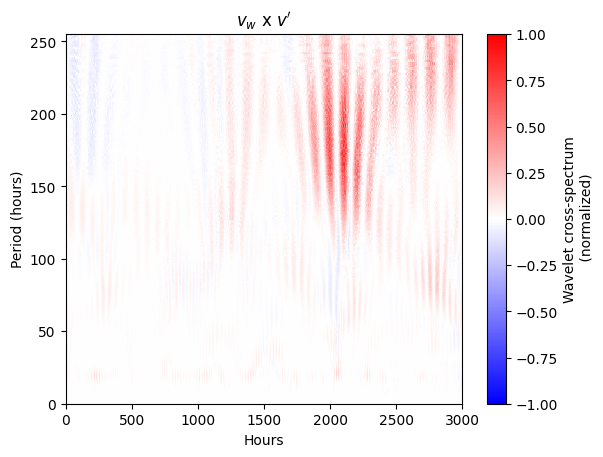

In [39]:
def cross_spectrum_paralel():
    for i in [1, 4, 10, 16, 19]:
        # Load data
        ocean_data = dfv.iloc[0:3000,i]
        ocean_data = add_noise(ocean_data, noise=r1)
        wind_data = add_noise(df_wind.wv.iloc[0:3000], noise=r1)

        # Define wavelet parameters
        dt = 1 # Time step of 1 hour
        scales = range(1,256) # Wavelet scales
        wavelet = 'morl' # Mother wavelet function

        # Perform wavelet analysis
        coefs_ocean, frequencies_ocean = pywt.cwt(ocean_data, scales, wavelet, dt)
        coefs_wind, frequencies_wind = pywt.cwt(wind_data, scales, wavelet, dt)

        # Calculate wavelet cross spectrum
        cross_spectrum = coefs_wind * np.conj(coefs_ocean)
        cross_spectrum = cross_spectrum/np.nanmax(abs(cross_spectrum))

        # Plot wavelet cross spectrum
        fig, ax = plt.subplots()
        cmap = plt.pcolormesh(np.real(cross_spectrum),vmin=-1, vmax=1, cmap=plt.cm.bwr)
        cbar = plt.colorbar(cmap)
        plt.title('$v_{w}$ x $v\'$')
        plt.xlabel('Hours')
        plt.ylabel('Period (hours)')
        cbar.set_label('Wavelet cross-spectrum\n (normalized)')
        plt.show()
        
cross_spectrum_paralel()